In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from mpl_toolkits import mplot3d
from sklearn.preprocessing import OrdinalEncoder
import optuna
from optuna.samplers import TPESampler      

# Different models

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

MERGE = True
TUNE = False
DECOMP = True
PCA_TRUE = True
TSNE_TRUE = True
UMAP_TRUE = True

<p style="text-align:center; font-size:30px; font-family:cursive;"> Welcome to PS_S3_Ep12 Challenge </p>

# Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e13/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e13/sample_submission.csv')
original = pd.read_csv('/kaggle/input/vector-borne-disease-prediction/trainn.csv')

replace_dict = {
    "Japanese encephalitis": "Japanese_encephalitis",
    "Rift Valley fever": "Rift_Valley_fever",
    "Yellow Fever": "Yellow_Fever",
    "West Nile fever": "West_Nile_fever",
    "Lyme disease": "Lyme_disease"
}

train["prognosis"] = train["prognosis"].replace(replace_dict)
original["prognosis"] = original["prognosis"].replace(replace_dict)

# Concatenate the training and original training dataset
if MERGE:    
    total_train = pd.concat([train, original])
    total_train.drop_duplicates(inplace=True)
    total_train.drop(['id'], axis=1, inplace=True)
else:
    total_train = train

In [3]:
total_train

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,Lyme_disease
248,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
249,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
250,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Lyme_disease


#### Seems like for this competition, there are a handful of features and are in binary data representation. 
#### I have a feeling for this competition, tree methods and simple models would get the job done accurately!

In [4]:
# Define our feature and target variables
features = list(total_train.columns[:-1])
target = 'prognosis'

# Data Visualization

#### Let's take a quick look at our data first.

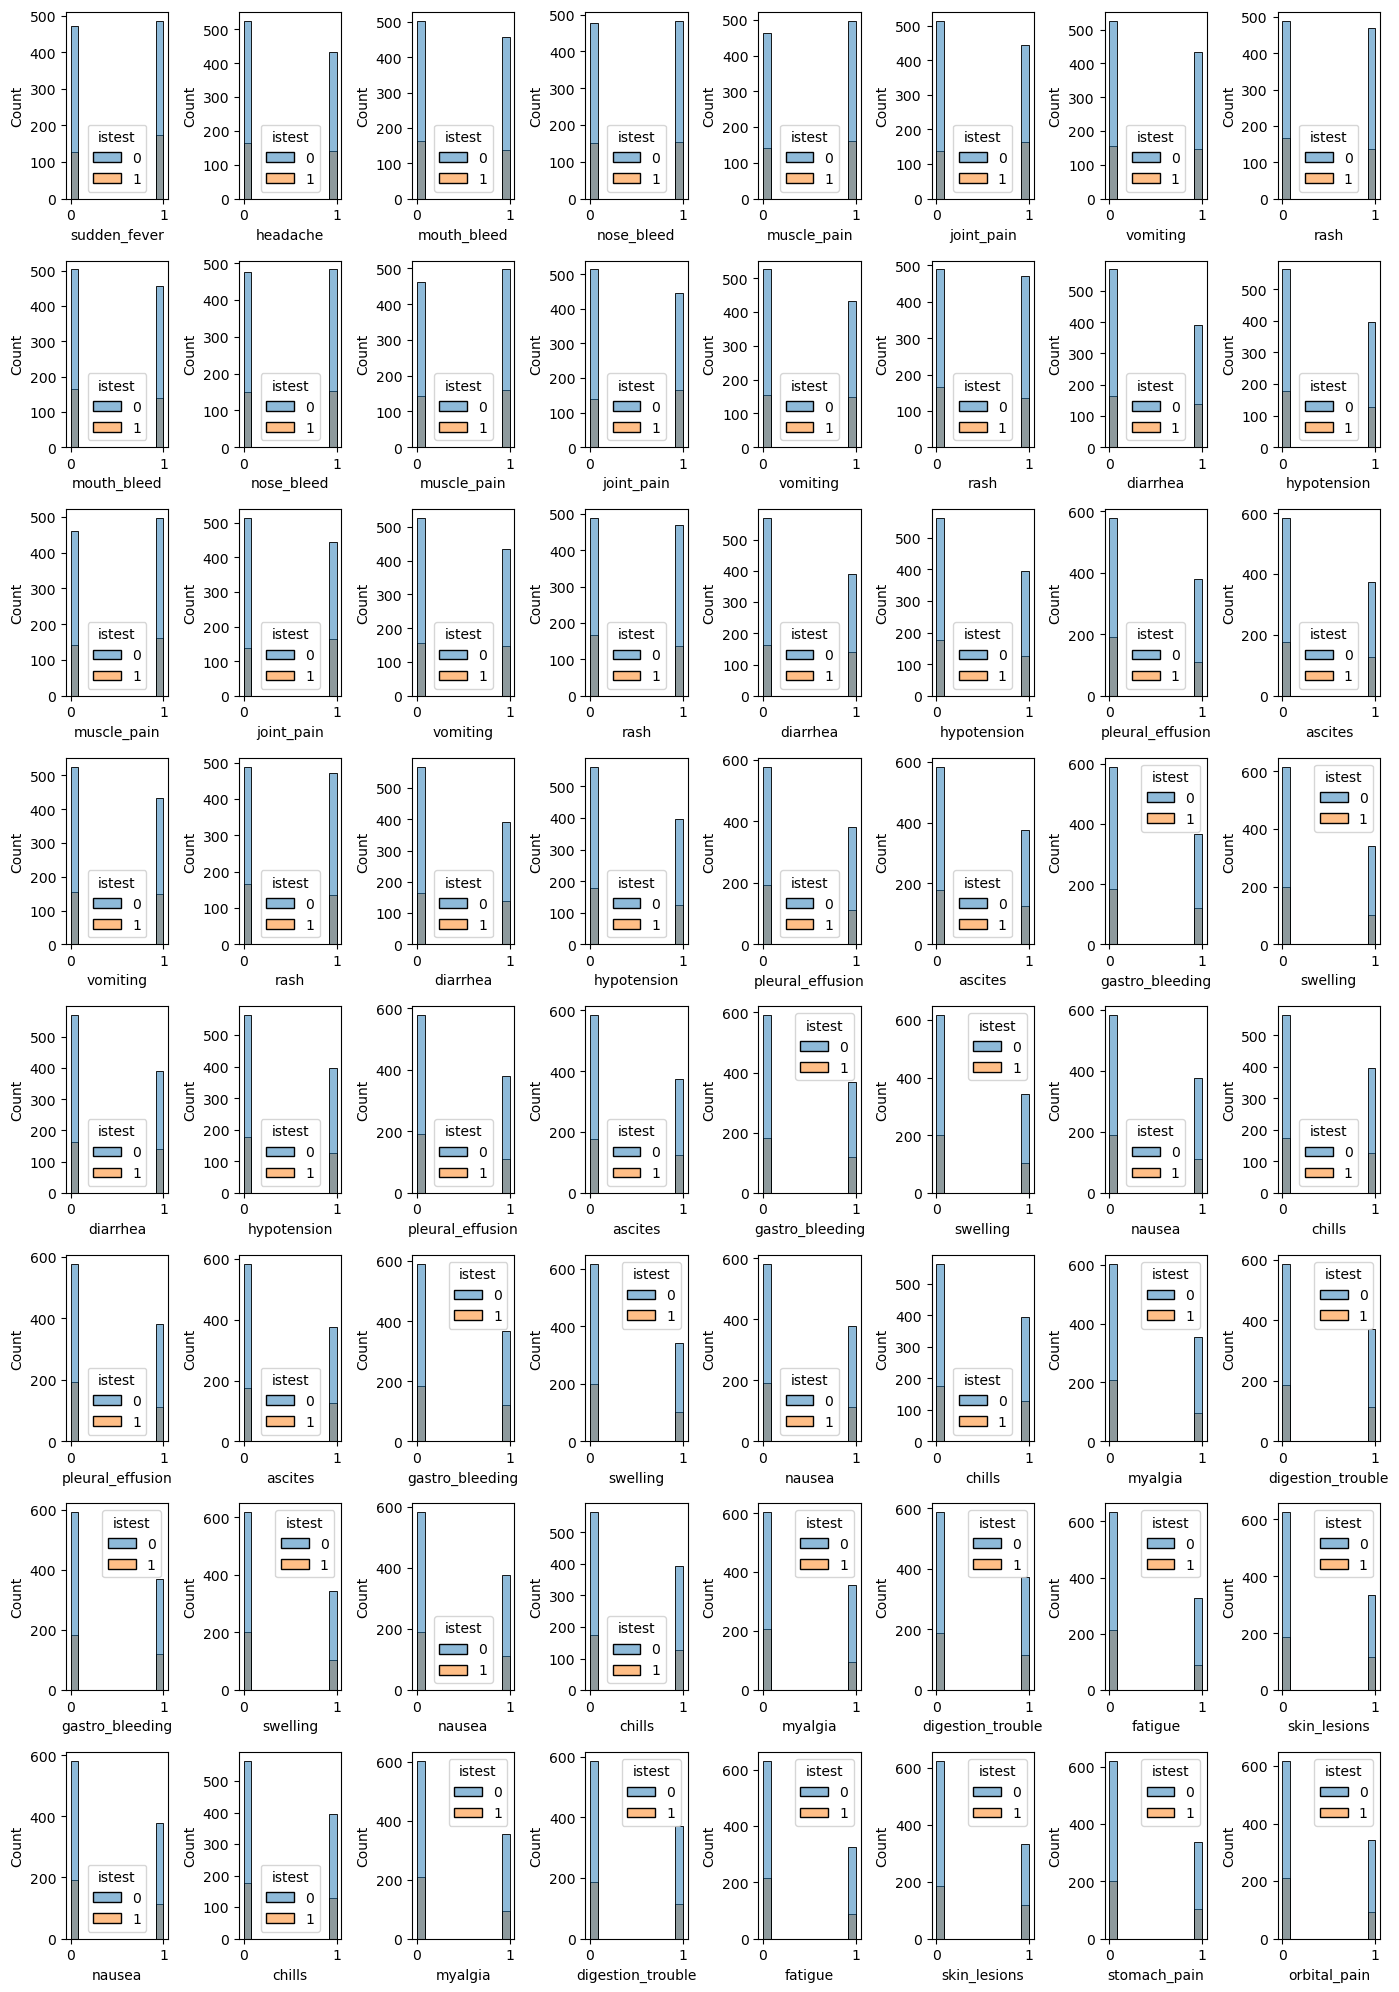

In [5]:
rows, cols = 8, 8
fig, axs = plt.subplots(rows, cols, figsize=(14,20))
total_train['istest'] = 0
test['istest'] = 1
features.extend(['istest'])
raw = pd.concat([total_train, test])
raw.reset_index(inplace=True)
for i in range(rows):
    for j in range(cols):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

#### Well, the obvious pattern here is that there is definitely a imbalance of data and most of the feature variables are leaning towards the value of 0. 
#### Let's look at the distribution of the target variable too while we're at it.

In [6]:
# Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
total_train['prognosis'] = enc.fit_transform(total_train[['prognosis']])

<AxesSubplot:xlabel='prognosis', ylabel='count'>

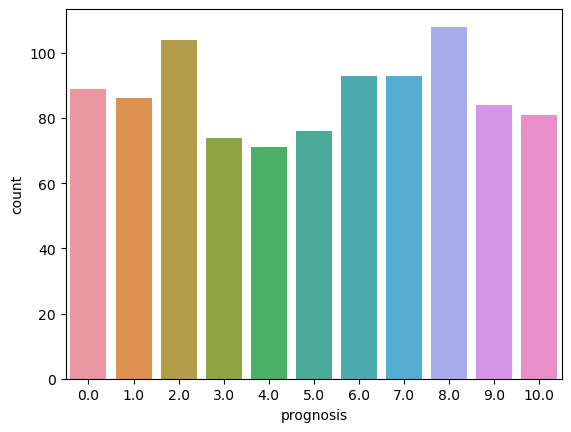

In [7]:
sns.countplot(x=total_train['prognosis'])

#### So there are a total of 11 categories in total and there is an uneven distribution. 

# Feature Engineering

#### There is a lot of feature variables so instead of engineering new features, we might want to focus on eliminating uninformative features and focusing on only the crucial ones. 
#### PCAs might also be useful in this scenario where it allows us to pick out components which convey useful information about the data.

<AxesSubplot:>

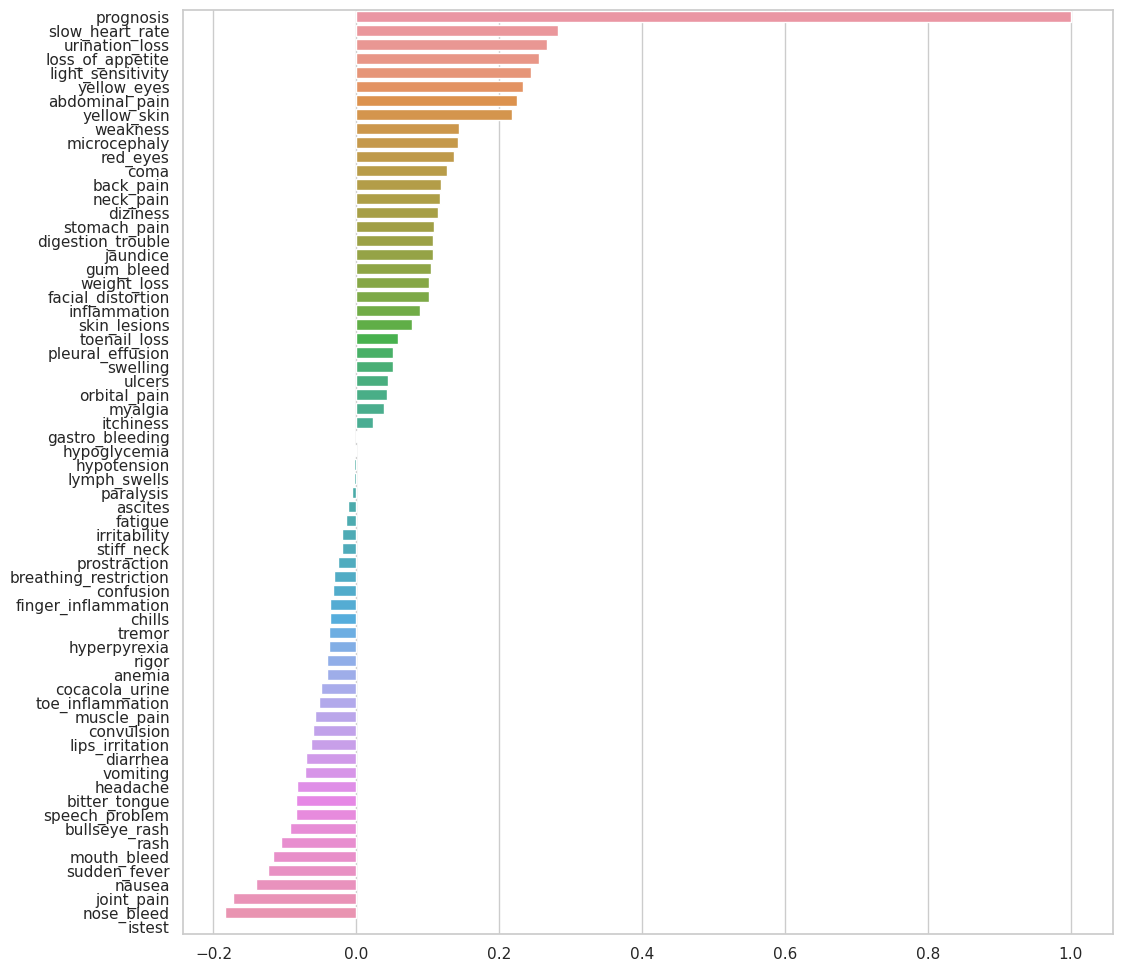

In [8]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 12))
sns.set_color_codes("pastel")
sns.barplot(x=total_train.corr()['prognosis'].sort_values(ascending=False).values, y=total_train.corr()['prognosis'].sort_values(ascending=False).index, orient='h')

#### Some of the features show close to 0 correlation with the target variable which could signal that it is useless to us. 
#### Let us proceed on to create some other features using decomposition techniques.

## Decomposition

In [9]:
if DECOMP:
    pca = PCA(n_components=3)
    tsne = TSNE(n_components=3)
    umap = UMAP(n_components=5)

    total_train['istest'] = 0
    test['istest'] = 1
    raw = pd.concat([total_train,test])
    
    if PCA_TRUE:
        raw[['pca_1', 'pca_2', 'pca_3']] = pca.fit_transform(raw[features])
    if TSNE_TRUE:
        raw[['tsne_1', 'tsne_2', 'tsne_3']] = tsne.fit_transform(raw[features])
    if UMAP_TRUE:
        raw[['umap_1', 'umap_2', 'umap_3', 'umap_4', 'umap_5']] = umap.fit_transform(raw[features])

    total_train = raw[raw['istest'] == 0]
    test = raw[raw['istest'] == 1]
    
    if PCA_TRUE:
        if 'pca_1' not in features and 'pca_2' not in features and 'pca_3' not in features:
            features+= ['pca_1', 'pca_2', 'pca_3']
    if TSNE_TRUE:
        if 'tsne_1' not in features and 'tsne_2' not in features and 'tsne_3' not in features:
            features+= ['tsne_1', 'tsne_2', 'tsne_3']
    if UMAP_TRUE:
        if 'umap_1' not in features and 'umap_2' not in features and 'umap_3' not in features and 'umap_4' not in features and 'umap_5' not in features:
            features+= ['umap_1', 'umap_2', 'umap_3', 'umap_4', 'umap_5']

#### Let's see where the principal components rank amongst the other features.

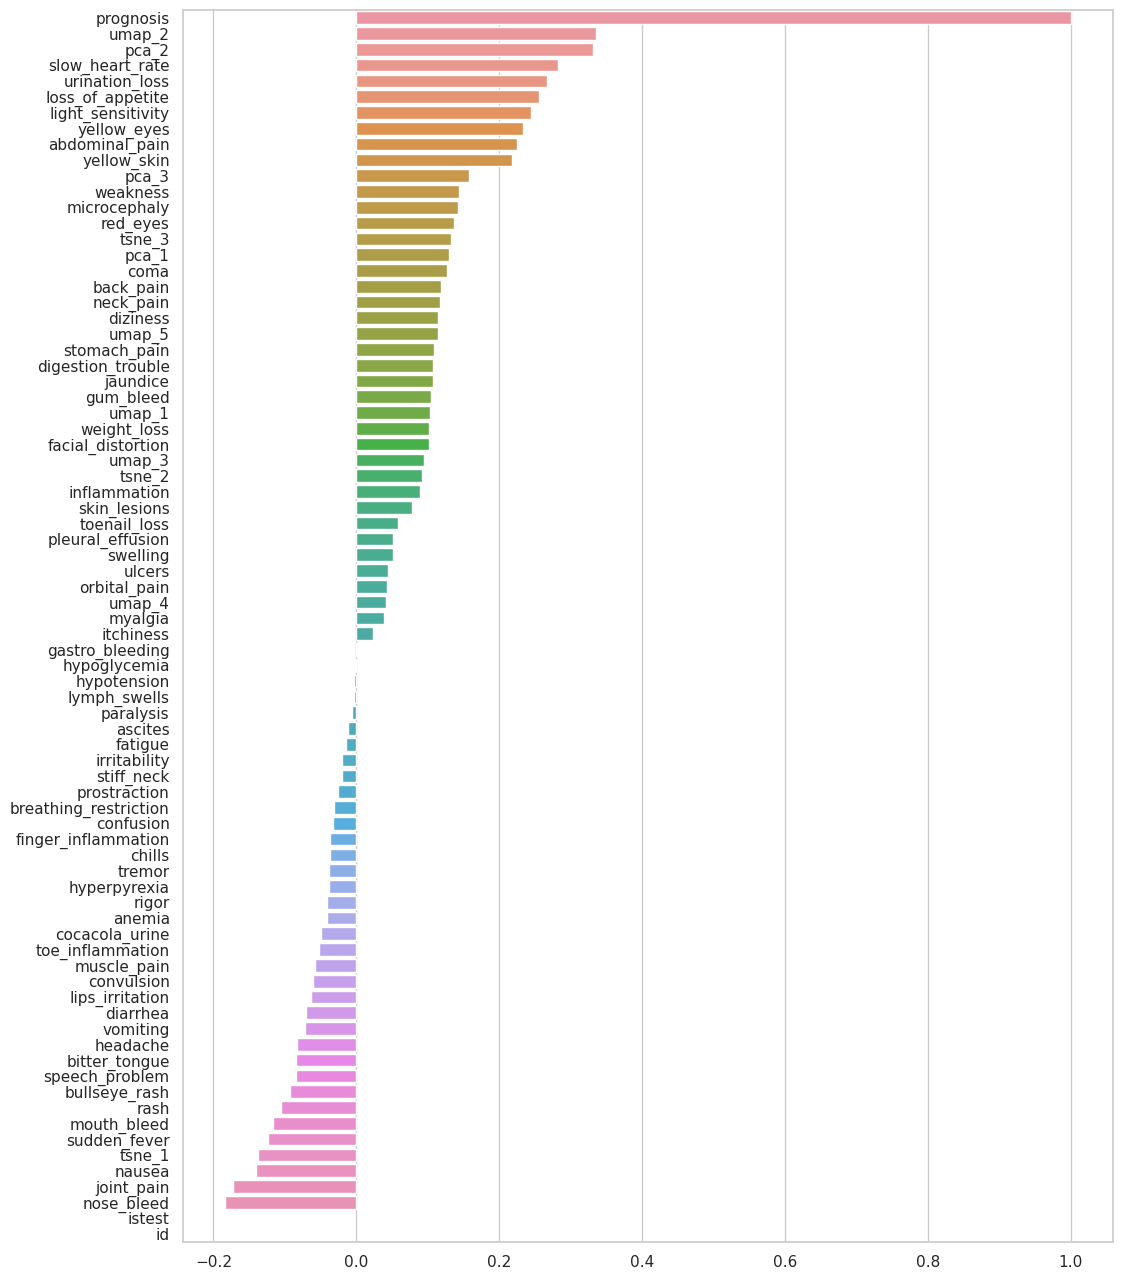

In [10]:
if DECOMP:
    sns.set_theme(style="whitegrid")
    f, ax = plt.subplots(figsize=(12, 16))
    sns.set_color_codes("pastel")
    sns.barplot(x=total_train.corr()['prognosis'].sort_values(ascending=False).values, y=total_train.corr()['prognosis'].sort_values(ascending=False).index, orient='h')

#### Let's try to visualize the decompositions.

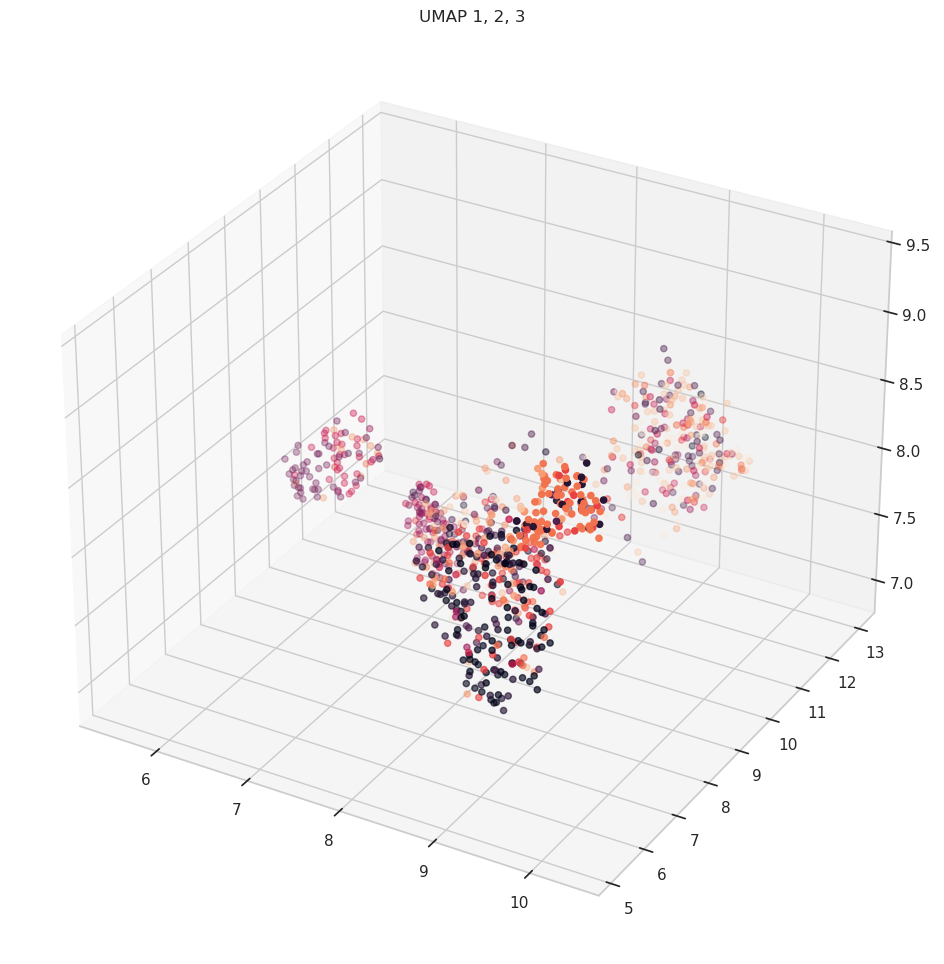

In [11]:
# We can only plot up to 3 dimensions
if UMAP_TRUE:
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    ax.scatter3D(total_train['umap_1'], total_train['umap_2'], total_train['umap_3'], c=total_train['prognosis']);
    ax.set_title('UMAP 1, 2, 3')

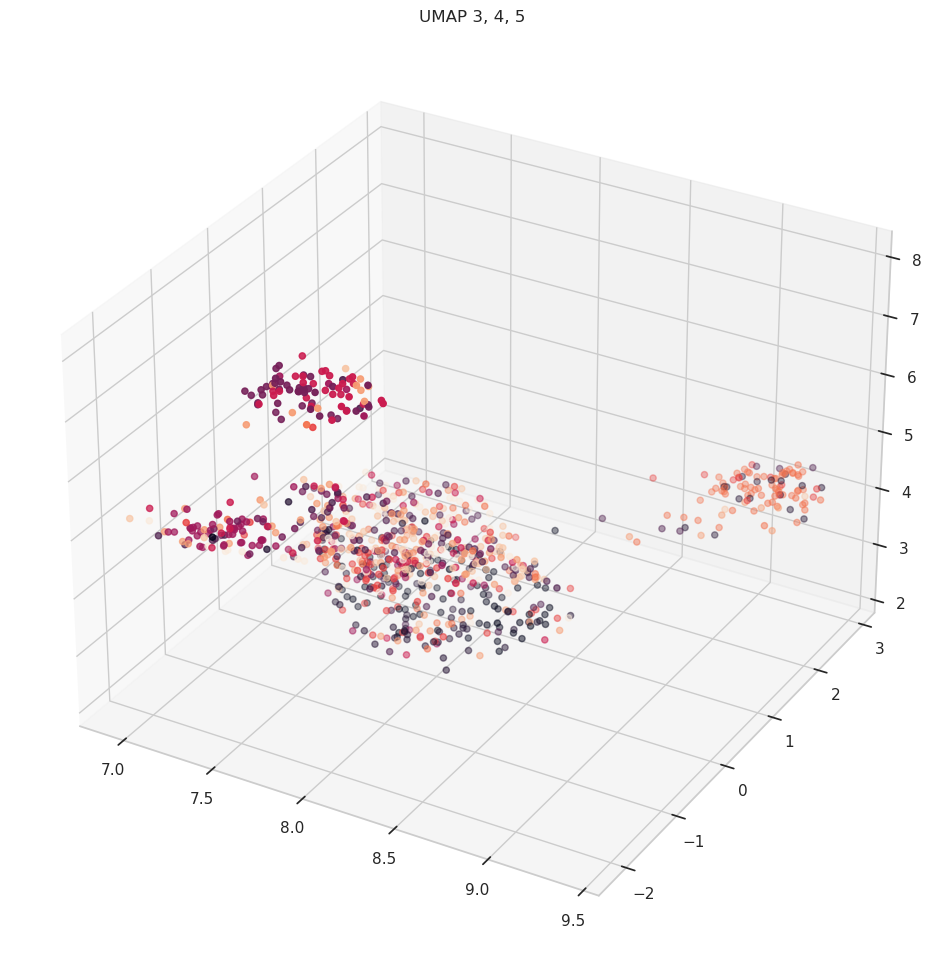

In [12]:
# We can only plot up to 3 dimensions
if UMAP_TRUE:
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    ax.scatter3D(total_train['umap_3'], total_train['umap_4'], total_train['umap_5'], c=total_train['prognosis']);
    ax.set_title('UMAP 3, 4, 5')

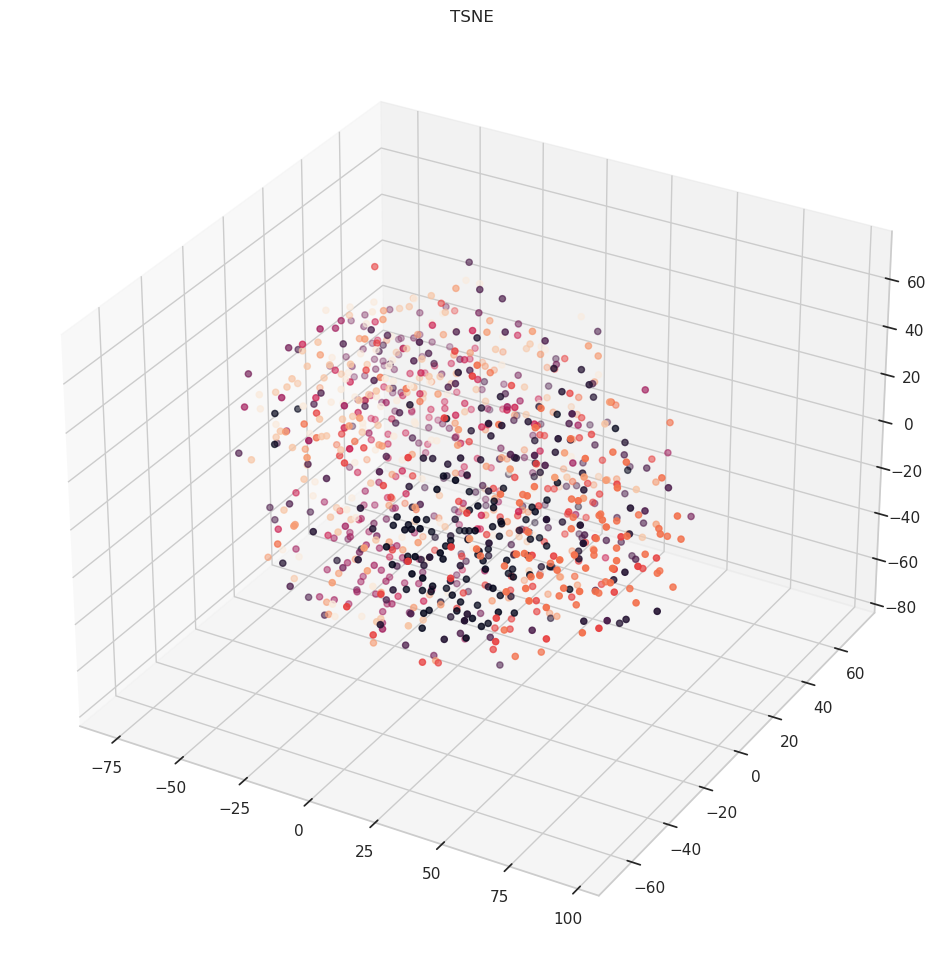

In [13]:
if TSNE_TRUE:
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    ax.scatter3D(total_train['tsne_1'], total_train['tsne_2'], total_train['tsne_3'], c=total_train['prognosis']);
    ax.set_title('TSNE')

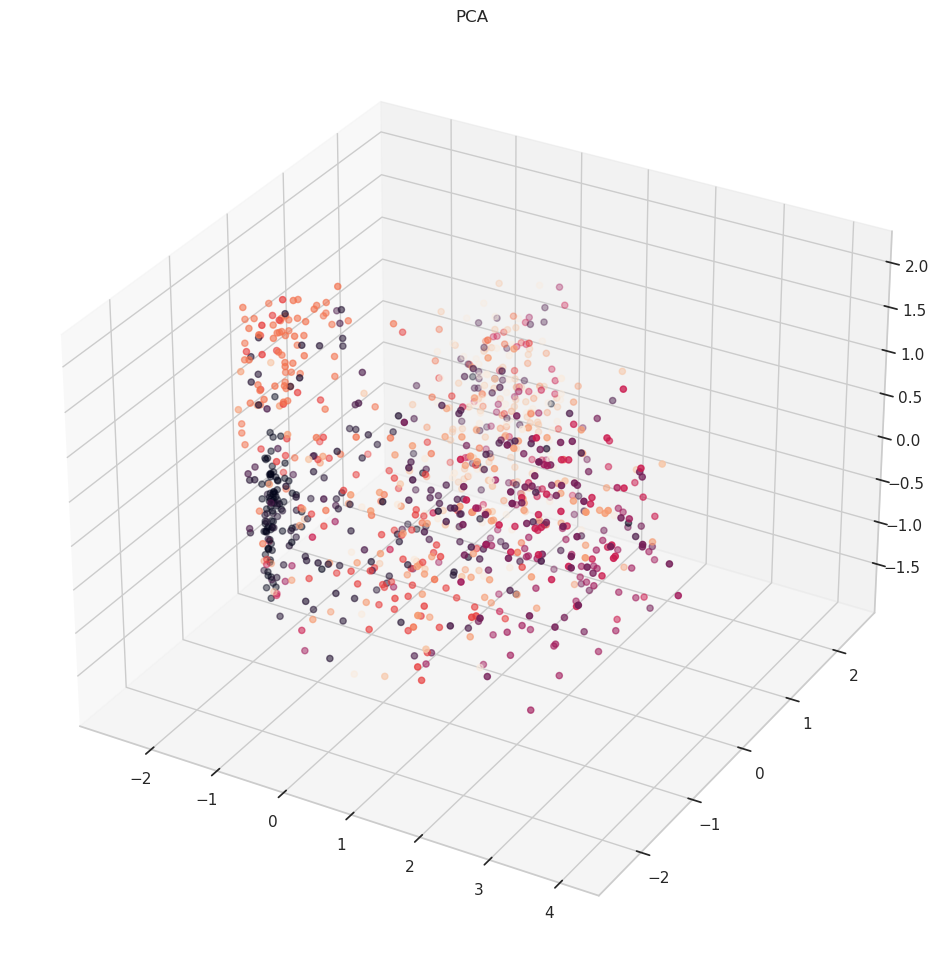

In [14]:
if PCA_TRUE:
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')
    ax.scatter3D(total_train['pca_1'], total_train['pca_2'], total_train['pca_3'], c=total_train['prognosis']);
    ax.set_title('PCA')

#### With these upper dimensional plots, we can take a look at the need for a higher dimension decomposition. The PCA and TSNE shows very little discrimination between different classes while the UMAP technique, which has a dimension of 5, shows a slightly more active decomposition. 
#### We might want to try out PCA and TSNE with a higher dimension value. 

# Modeling

#### We would first need to set up the evaluation function.
#### Visit this [notebook](https://www.kaggle.com/code/wlifferth/generating-map-k-predictions) which I found very useful to help me get off the ground with this week's playground series.

In [15]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [16]:
y = total_train[target]
X = total_train[features]

# Score dictionary to keep track of various model's performance.
score = {}

## Logistic Regression

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
LR_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    LR_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['lr'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['lr'])

#########################
### Fold 1
#########################
Score: 0.4704861111111111
#########################
### Fold 2
#########################
Score: 0.4453125
#########################
### Fold 3
#########################
Score: 0.4348958333333333
#########################
### Fold 4
#########################
Score: 0.4322916666666667
#########################
### Fold 5
#########################
Score: 0.4293193717277487


Average Vaildation Score: 0.44246109656777194


## Decision Tree

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
DT_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    DT_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['DT'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['DT'])

#########################
### Fold 1
#########################
Score: 0.24479166666666666
#########################
### Fold 2
#########################
Score: 0.23177083333333334
#########################
### Fold 3
#########################
Score: 0.30121527777777773
#########################
### Fold 4
#########################
Score: 0.2725694444444445
#########################
### Fold 5
#########################
Score: 0.2844677137870855


Average Vaildation Score: 0.2669629872018615


## KNN

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
KNN_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = KNeighborsClassifier() # Model going to be used
    model.fit(X_train, y_train)

    KNN_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['KNN'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['KNN'])

#########################
### Fold 1
#########################
Score: 0.36284722222222227
#########################
### Fold 2
#########################
Score: 0.3645833333333333
#########################
### Fold 3
#########################
Score: 0.36371527777777785
#########################
### Fold 4
#########################
Score: 0.3897569444444445
#########################
### Fold 5
#########################
Score: 0.33158813263525305


Average Vaildation Score: 0.3624981820826062


# Random Forest Classifier

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
RF_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = RandomForestClassifier(n_estimators=1000) # Model going to be used
    model.fit(X_train, y_train)

    RF_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['RF'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['RF'])

#########################
### Fold 1
#########################
Score: 0.4704861111111111
#########################
### Fold 2
#########################
Score: 0.44878472222222227
#########################
### Fold 3
#########################
Score: 0.4618055555555555
#########################
### Fold 4
#########################
Score: 0.46875
#########################
### Fold 5
#########################
Score: 0.4328097731239092


Average Vaildation Score: 0.4565272324025596


## SVC

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
SVC_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = SVC(probability=True, random_state=42) # Model going to be used
    model.fit(X_train, y_train)

    SVC_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['SVC'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['SVC'])

#########################
### Fold 1
#########################
Score: 0.4401041666666667
#########################
### Fold 2
#########################
Score: 0.44184027777777773
#########################
### Fold 3
#########################
Score: 0.40798611111111116
#########################
### Fold 4
#########################
Score: 0.42795138888888884
#########################
### Fold 5
#########################
Score: 0.3787085514834206


Average Vaildation Score: 0.419318099185573


## Gradient Boosting Classifier

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
GBC_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = GradientBoostingClassifier(random_state=42) # Model going to be used
    model.fit(X_train, y_train)

    GBC_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['GBC'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['GBC'])

#########################
### Fold 1
#########################
Score: 0.4505208333333333
#########################
### Fold 2
#########################
Score: 0.4392361111111111
#########################
### Fold 3
#########################
Score: 0.42621527777777773
#########################
### Fold 4
#########################
Score: 0.41579861111111116
#########################
### Fold 5
#########################
Score: 0.3865619546247818


Average Vaildation Score: 0.4236665575916231


## AdaBoostClassifier

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
ADA_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = AdaBoostClassifier(random_state=42) # Model going to be used
    model.fit(X_train, y_train)

    ADA_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['Ada'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['Ada'])

#########################
### Fold 1
#########################
Score: 0.3697916666666667
#########################
### Fold 2
#########################
Score: 0.33420138888888884
#########################
### Fold 3
#########################
Score: 0.3611111111111111
#########################
### Fold 4
#########################
Score: 0.3125
#########################
### Fold 5
#########################
Score: 0.35689354275741714


Average Vaildation Score: 0.34689954188481675


## MLPClassifier

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
MLP_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = MLPClassifier(random_state=42) # Model going to be used
    model.fit(X_train, y_train)

    MLP_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['MLP'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['MLP'])

#########################
### Fold 1
#########################
Score: 0.4539930555555555
#########################
### Fold 2
#########################
Score: 0.4270833333333333
#########################
### Fold 3
#########################
Score: 0.4001736111111111
#########################
### Fold 4
#########################
Score: 0.42013888888888884
#########################
### Fold 5
#########################
Score: 0.3970331588132635


Average Vaildation Score: 0.41968440954043046


## XGBClassifier

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
XGB_MODELS = []

xgb_params = {
    'booster': 'gbtree',
    'eval_metric': 'mlogloss',
    'objective': 'multi:softprob',
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 9999,
    'early_stopping_rounds': 200,
    'tree_method':'gpu_hist',
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'random_state': 42
}

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = XGBClassifier(**xgb_params) # Model going to be used
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=False)

    XGB_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['XGB'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['XGB'])

#########################
### Fold 1
#########################
Score: 0.47222222222222215
#########################
### Fold 2
#########################
Score: 0.46875
#########################
### Fold 3
#########################
Score: 0.4583333333333333
#########################
### Fold 4
#########################
Score: 0.4288194444444444
#########################
### Fold 5
#########################
Score: 0.4109947643979058


Average Vaildation Score: 0.4478239528795811


## LGBMClassifier

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
LGBM_MODELS = []

lgbm_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_iterations' : 9999,
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 500,
    'early_stopping_rounds': 200,
    'device':'gpu',
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'random_state': 42
}

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = LGBMClassifier(**lgbm_params) # Model going to be used
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=False)

    LGBM_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['LGBM'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['LGBM'])

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
Score: 0.4774305555555555
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
Score: 0.4626736111111111
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
Score: 0.48784722222222215
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
Score: 0.44184027777777773
#########################
### Fold 5
#########################
[LightGBM] [Warning] early_stop

## CatBoostClassifier

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
CAT_MODELS = []

catboost_params = {
    'iterations': 9999,
    'learning_rate': 0.1,
    'depth': 7,
    'l2_leaf_reg':8 ,
    'random_strength':0.5,
    'eval_metric': 'MultiClass',
    'loss_function': 'MultiClass',
    'grow_policy': 'Depthwise',
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'task_type': 'GPU',
    'border_count': 128,
    'verbose': False,
    'early_stopping_rounds': 200,
    'use_best_model': True ,
    'random_state': 42,
}

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = CatBoostClassifier(**catboost_params) # Model going to be used
    model.fit(X_train, y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=False)

    CAT_MODELS.append( model )
    
    # Obtaining the top 3 results
    predictions = model.predict_proba(X_valid)
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['CAT'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['CAT'])

#########################
### Fold 1
#########################
Score: 0.4852430555555555
#########################
### Fold 2
#########################
Score: 0.47222222222222215
#########################
### Fold 3
#########################
Score: 0.47309027777777773
#########################
### Fold 4
#########################
Score: 0.4505208333333333
#########################
### Fold 5
#########################
Score: 0.4075043630017452


Average Vaildation Score: 0.45771615037812674


# Visualization of model's performance

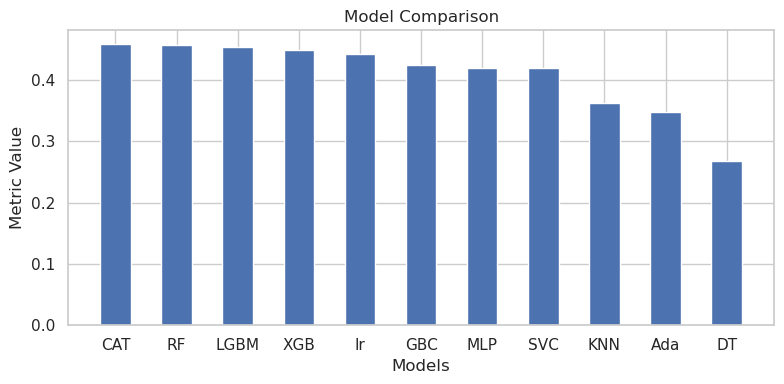

In [28]:
fig = plt.figure(figsize = (8,4))
scores = dict(sorted(score.items(), key=lambda item: -1*item[1]))
# creating the bar plot
plt.bar(scores.keys(), scores.values(), width = 0.5)
 
plt.xlabel("Models")
plt.ylabel("Metric Value")
plt.title("Model Comparison")
plt.tight_layout()
plt.show()

#### Let's see if we can tune the hyperparameters for a better performance.

# Hyperparameter Tuning

## Tuning for XGBClassifier

In [29]:
def objective(trial):  
    
    xgb_params = {
    'booster': 'gbtree',
    'eval_metric': 'mlogloss',
    'objective': 'multi:softprob',
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
    'max_depth': trial.suggest_int('max_depth', 1, 15),
    'n_estimators': 9999,
    'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500),
    'tree_method':'gpu_hist',
    'subsample': trial.suggest_float('subsample', 0.01, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
    'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        X_valid = X.iloc[valid_index]
        y_valid = y.iloc[valid_index]

        model = XGBClassifier(**xgb_params) # Model going to be used
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 verbose=False)

        # Obtaining the top 3 results
        predictions = model.predict_proba(X_valid)
        sorted_prediction_ids = np.argsort(-predictions, axis=1)
        top_3_prediction_ids = sorted_prediction_ids[:,:3]
        original_shape = top_3_prediction_ids.shape
        top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
        top_3_predictions = top_3_predictions.reshape(original_shape)

        metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
        print(f"Score: {metric}")
        scores.append(metric)

    return sum(scores)/5

if TUNE:
    xgb_tuning = optuna.create_study(direction='maximize', sampler = TPESampler())
    optuna.logging.set_verbosity(optuna.logging.INFO)
    xgb_tuning.optimize(func=objective, n_trials=100)
    print(xgb_tuning.best_params)

## Tuning for LGMBClassifier

In [30]:
def objective(trial):  
    
    lgbm_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_iterations' : 9999,
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
    'max_depth': trial.suggest_int('max_depth', 1, 15),
    'num_leaves': 500,
    'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500),
    'tree_method':'gpu_hist',
    'subsample': trial.suggest_float('subsample', 0.01, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
    'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        X_valid = X.iloc[valid_index]
        y_valid = y.iloc[valid_index]

        model = LGBMClassifier(**lgbm_params) # Model going to be used
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 verbose=False)

        # Obtaining the top 3 results
        predictions = model.predict_proba(X_valid)
        sorted_prediction_ids = np.argsort(-predictions, axis=1)
        top_3_prediction_ids = sorted_prediction_ids[:,:3]
        original_shape = top_3_prediction_ids.shape
        top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
        top_3_predictions = top_3_predictions.reshape(original_shape)

        metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
        scores.append(metric)

    return sum(scores)/5

if TUNE:
    lgbm_tuning = optuna.create_study(direction='maximize', sampler = TPESampler())
    optuna.logging.set_verbosity(optuna.logging.INFO)
    lgbm_tuning.optimize(func=objective, n_trials=100)
    print(lgbm_tuning.best_params)

## Tuning for CatBoostClassifier

In [31]:
def objective(trial):  
    
    catboost_params = {
    'iterations': 9999,
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
    'max_depth': trial.suggest_int('max_depth', 1, 15),
    'l2_leaf_reg':8 ,
    'random_strength':0.5,
    'eval_metric': 'MultiClass',
    'loss_function': 'MultiClass',
    'grow_policy': 'Depthwise',
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'task_type': 'GPU',
    'border_count': 128,
    'verbose': False,
    'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500),
    'use_best_model': True ,
    'random_state': 42,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        X_valid = X.iloc[valid_index]
        y_valid = y.iloc[valid_index]

        model = CatBoostClassifier(**catboost_params) # Model going to be used
        model.fit(X_train, y_train,
                 eval_set=[(X_valid, y_valid)],
                 verbose=False)

        # Obtaining the top 3 results
        predictions = model.predict_proba(X_valid)
        sorted_prediction_ids = np.argsort(-predictions, axis=1)
        top_3_prediction_ids = sorted_prediction_ids[:,:3]
        original_shape = top_3_prediction_ids.shape
        top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
        top_3_predictions = top_3_predictions.reshape(original_shape)

        metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
        scores.append(metric)

    return sum(scores)/5

if TUNE:
    catboost_tuning = optuna.create_study(direction='maximize', sampler = TPESampler())
    optuna.logging.set_verbosity(optuna.logging.INFO)
    catboost_tuning.optimize(func=objective, n_trials=100)
    print(catboost_tuning.best_params)

# Final Results

In [32]:
xgb_tuned = {
    'booster': 'gbtree',
    'eval_metric': 'mlogloss',
    'objective': 'multi:softprob',
    'learning_rate': 0.0820883225084806, 
    'max_depth': 12, 
    'n_estimators': 9999,
    'tree_method':'gpu_hist',
    'early_stopping_rounds': 429, 
    'subsample': 0.4670258600309255, 
    'colsample_bytree': 0.7296919462939587,
    'random_state': 42
}

lgbm_tuned = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_iterations' : 9999,
    'learning_rate': 0.056611678420173506,
    'max_depth': 1,
    'num_leaves': 500,
    'early_stopping_rounds': 249,
    'device': 'gpu',
    'subsample': 0.39964585450841017,
    'colsample_bytree': 0.449575806086925,
    'random_state': 42
}

catboost_tuned = {
    'iterations': 9999,
    'learning_rate': 0.1032169736475615,
    'max_depth': 4,
    'l2_leaf_reg':8 ,
    'random_strength':0.5,
    'eval_metric': 'MultiClass',
    'loss_function': 'MultiClass',
    'grow_policy': 'Depthwise',
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'task_type': 'GPU',
    'border_count': 128,
    'verbose': False,
    'early_stopping_rounds': 359,
    'use_best_model': True ,
    'random_state': 42,
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
XGB_MODELS = []
LGBM_MODELS = []
CAT_MODELS = []
SVC_MODELS = []
RF_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    XGB_tuned = XGBClassifier(**xgb_tuned)
    LGBM_tuned = LGBMClassifier(**lgbm_tuned)
    CAT_tuned = CatBoostClassifier(**catboost_tuned)
    svc = SVC(probability=True)
    rf = RandomForestClassifier(n_estimators=1000)
    
    # Fitting these 3 models
    XGB_tuned.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=False)
    XGB_MODELS.append( XGB_tuned )
    
    LGBM_tuned.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=False)
    LGBM_MODELS.append( LGBM_tuned )
    
    CAT_tuned.fit(X_train, y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=False)
    CAT_MODELS.append( CAT_tuned )
    
    svc.fit(X_train, y_train)
    SVC_MODELS.append( svc )
    
    rf.fit(X_train, y_train)
    RF_MODELS.append( rf )
    
    # Predicting
    XGB_predictions = XGB_tuned.predict_proba(X_valid)
    LGBM_predictions = LGBM_tuned.predict_proba(X_valid)
    CAT_predictions = CAT_tuned.predict_proba(X_valid)
    SVC_predictions = svc.predict_proba(X_valid)
    RF_predictions = rf.predict_proba(X_valid)
    
    total_pred = (XGB_predictions + LGBM_predictions + CAT_predictions + SVC_predictions + RF_predictions) / 5
    
    # Obtaining the top 3 results
    predictions = total_pred
    sorted_prediction_ids = np.argsort(-predictions, axis=1)
    top_3_prediction_ids = sorted_prediction_ids[:,:3]
    original_shape = top_3_prediction_ids.shape
    top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
    top_3_predictions = top_3_predictions.reshape(original_shape)
    
    metric = mapk(y_valid.values.reshape(-1, 1), top_3_prediction_ids, k=3)
    print(f"Score: {metric}")
    scores.append(metric)
    
score['Ensemble'] = sum(scores)/5
print('\n')
print(f'Average Vaildation Score:', score['Ensemble'])

[LightGBM] [Warning] early_stopping_round is set=249, early_stopping_rounds=249 will be ignored. Current value: early_stopping_round=249
Score: 0.4791666666666667
[LightGBM] [Warning] early_stopping_round is set=249, early_stopping_rounds=249 will be ignored. Current value: early_stopping_round=249
Score: 0.4774305555555555
[LightGBM] [Warning] early_stopping_round is set=249, early_stopping_rounds=249 will be ignored. Current value: early_stopping_round=249
Score: 0.484375
[LightGBM] [Warning] early_stopping_round is set=249, early_stopping_rounds=249 will be ignored. Current value: early_stopping_round=249
Score: 0.4670138888888889
[LightGBM] [Warning] early_stopping_round is set=249, early_stopping_rounds=249 will be ignored. Current value: early_stopping_round=249
Score: 0.43455497382198954


Average Vaildation Score: 0.46850821698662015


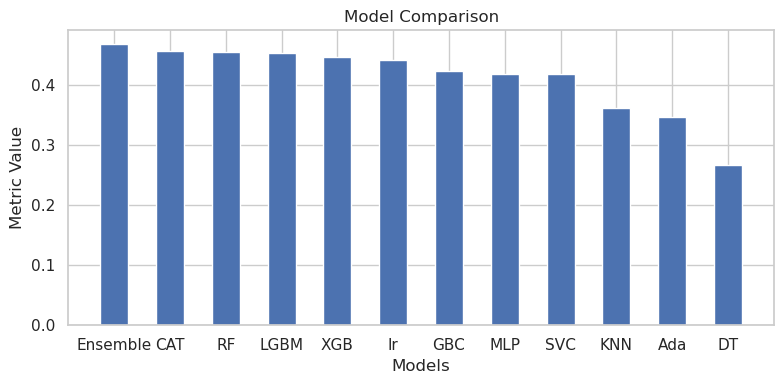

In [33]:
fig = plt.figure(figsize = (8,4))
scores = dict(sorted(score.items(), key=lambda item: -1*item[1]))
# creating the bar plot
plt.bar(scores.keys(), scores.values(), width = 0.5)
 
plt.xlabel("Models")
plt.ylabel("Metric Value")
plt.title("Model Comparison")
plt.tight_layout()
plt.show()

#### It seems like obtaining the average results of these 3 tuned models seem to provide the highest score!
#### Let us go about submitting this.

# Submission

In [34]:
total_pred = np.zeros((303,11))
for i in range(5):
    total_pred += (LGBM_MODELS[i].predict_proba(test[features]) + XGB_MODELS[i].predict_proba(test[features]) + CAT_MODELS[i].predict_proba(test[features]) + SVC_MODELS[i].predict_proba(test[features]) + RF_MODELS[i].predict_proba(test[features])) / 5

total_pred /= 5

predictions = total_pred
sorted_prediction_ids = np.argsort(-predictions, axis=1)
top_3_prediction_ids = sorted_prediction_ids[:,:3]
original_shape = top_3_prediction_ids.shape
top_3_predictions = enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))
top_3_predictions = top_3_predictions.reshape(original_shape)

sample['prognosis'] = np.apply_along_axis(lambda x: np.array(' '.join(x), dtype="object"), 1, top_3_predictions)

sample['prognosis'][:10] # Just to check

0                   Tungiasis Dengue Rift_Valley_fever
1                     Dengue Rift_Valley_fever Malaria
2             Dengue Rift_Valley_fever West_Nile_fever
3       Dengue Rift_Valley_fever Japanese_encephalitis
4    West_Nile_fever Japanese_encephalitis Rift_Val...
5                             Yellow_Fever Zika Plague
6                 Malaria Plague Japanese_encephalitis
7                 Dengue Rift_Valley_fever Chikungunya
8              Yellow_Fever Zika Japanese_encephalitis
9                    Zika Yellow_Fever West_Nile_fever
Name: prognosis, dtype: object

In [35]:
sample.to_csv('submission.csv', columns=['id', 'prognosis'], index=False)